In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import pickle
import itertools

import warnings
warnings.simplefilter('ignore')

Загружаем подготовленный тренировочный датасет с признаками:

In [2]:
train_data = pd.read_csv('train_data_features.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808738 entries, 0 to 808737
Columns: 259 entries, id to month
dtypes: float64(254), int64(5)
memory usage: 1.6 GB


In [4]:
train_data[train_data.select_dtypes(np.float64).columns] = train_data.select_dtypes(np.float64).astype(np.float32)

In [5]:
train_data.head(4)

,id,vas_id,target,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,day,week,month
0,2814496,2,0.0,-96.799973,430.990875,-110.740784,378.383209,-116.158249,357.278198,-16.08618,...,-37.630447,-291.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,9,1,7
1,212196,4,0.0,-96.799973,7.070888,-110.740784,-45.536797,-116.158249,-66.641792,-16.08618,...,-37.630447,-195.747726,-24.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
2,3929509,2,0.0,-56.129971,164.690887,10.429214,1116.273193,5.011754,1095.168213,24.58382,...,-37.630447,-302.747711,-24.832888,-0.694429,-11.175933,-0.45614,0.0,9,1,7
3,2379697,2,0.0,-96.799973,100.290886,-110.740784,47.683201,-116.158249,26.578211,-16.08618,...,-37.630447,-220.747726,-22.832888,-0.694429,-10.175933,-0.45614,0.0,9,1,7


#### Работа с признаками

Разделим признаки и целевую переменную:

In [6]:
data_prelim = train_data.copy()

X = data_prelim.drop('target', axis=1)
y = data_prelim['target']

In [7]:
print('ID уникален?', X.index.is_unique)
print('Есть ли дубли в строках?', X.duplicated().sum())
print(f'Сколько процент признаков могут принимать null-значениями? {float((X.isnull().sum() > 0).sum() / X.shape[1]):.2%}')

ID уникален? True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0.00%


0.0    0.944645
1.0    0.055355
Name: target, dtype: float64

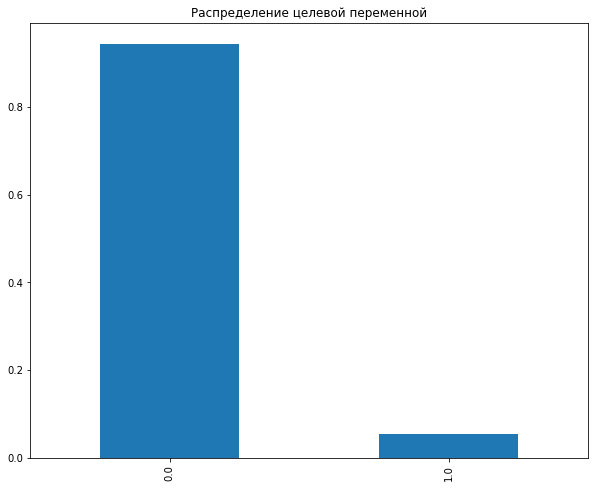

In [8]:
(y.value_counts() / y.shape[0]).plot(kind='bar', title='Распределение целевой переменной');
y.value_counts() / y.shape

Наблюдается некоторый дисбаланс в распределении целевой переменной, поэтому в дальнейшем попробуем сделать балансировку данных.

In [9]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [10]:
X_nunique.shape

(258,)

In [11]:
f_all = set(X_nunique.index.tolist())
len(f_all)

258

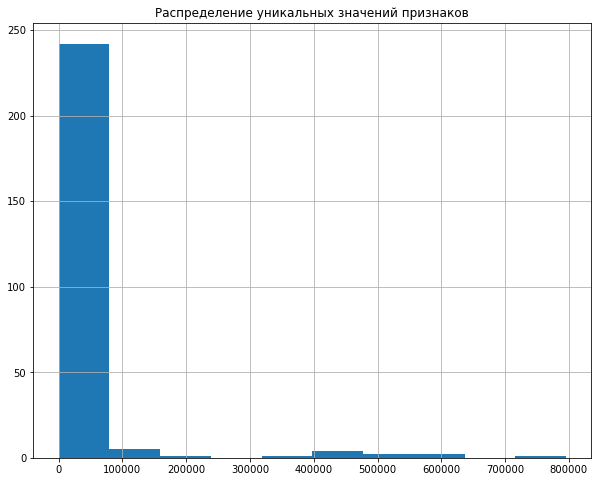

In [12]:
plt.title('Распределение уникальных значений признаков');
X_nunique.hist();

Отберём константные признаки:

In [13]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())

f_other = f_all - f_const

len(f_const), len(f_other)

(5, 253)

Отберём бинарные признаки:

In [14]:
f_binary = set(X.loc[:, f_other].columns[(
    (X.loc[:, f_other].max() == 1) & \
    (X.loc[:, f_other].min() == 0) & \
    (X.loc[:, f_other].isnull().sum() == 0))])

f_other = f_other - f_binary

len(f_binary), len(f_other)

(0, 253)

Отберём категориальные признаки:

In [15]:
f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())

f_other = f_other - f_categorical

len(f_categorical), len(f_other)

(32, 221)

Отберём вещественные признаки:

In [16]:
f_numeric = (X[f_other].fillna(0).astype(int).sum() - X[f_other].fillna(0).sum()).abs() 
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())

f_other = f_other - f_numeric

len(f_numeric), len(f_other)

(218, 3)

In [17]:
f_numeric = f_numeric | f_other
f_other = f_other - f_numeric

len(f_other)

0

In [18]:
assert(X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_categorical) + len(f_numeric))

In [19]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(f_binary))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_binary | f_categorical | f_numeric)
f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

f_all: 258

f_const: 5
f_binary: 0
f_categorical: 32
f_numeric: 221


#### Train / Test

In [20]:
RANDOM_STATE = 41

In [21]:
train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

#### Балансировка данных

Выполним балансировку данных в тренировочной выборке при помощи RandomUnderSampler:

In [22]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(X_train, y_train)

print('Train')
print(y_train.value_counts() / y_train.shape[0])
print()
print('Test')
print(y_test.value_counts() / y_test.shape[0])

Train
0.0    0.5
1.0    0.5
Name: target, dtype: float64

Test
0.0    0.943868
1.0    0.056132
Name: target, dtype: float64


#### Построение пайплайнов, обучение моделей

In [23]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame не содержит следующие колонки: {cols_error}')

In [24]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ('numeric_features', make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            PCA()
        )),
        ('categorical_features', make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ('boolean_features', make_pipeline(
            ColumnSelector(f_binary)
        ))
    ])
)

In [25]:
f_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['224', '87', '122', '199', '8', '137', '217', '44',
                          '25', '248', '80', '37', '74', '26', '107', '227', '22',
                          '192', '180', '13', '168', '117', '105', '118', '102',
                          '236', '42', '152', '47', '70', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['224',
                                                                           '87',
                                                                           '122',
                                                                           '8',
                                                                           '137',
                                                                           '217',
                                          

In [26]:
X_test.shape[1]

258

In [27]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

305

Для автоматического подбора параметров будем использовать GridSearchCV:

In [28]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print('Best %s score: %.2f' % (scoring, gsc.best_score_))
    print()
    print('Best parameters set found on development set:')
    print()
    print(gsc.best_params_)
    print()
    print('Grid scores on development set:')
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print('%0.3f (+/-%0.03f) for %r'
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [29]:
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

Попробуем несколько моделей:

1) LogisticRegression

In [30]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [31]:
param_grid = {
    'pipeline__featureunion__categorical_features__simpleimputer__strategy': ['most_frequent', 'constant'],
    'pipeline__featureunion__categorical_features__simpleimputer__fill_value': [-1],
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.91

Best parameters set found on development set:

{'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}

Grid scores on development set:

0.908 (+/-0.002) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'most_frequent'}
0.908 (+/-0.002) for {'pipeline__featureunion__categorical_features__simpleimputer__fill_value': -1, 'pipeline__featureunion__categorical_features__simpleimputer__strategy': 'constant'}



Разницы нет, оставим по умолчанию.

In [32]:
param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.01, 0.1, 5.0]
}

lg_gsc = run_grid_search(lg_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.91

Best parameters set found on development set:

{'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}

Grid scores on development set:

nan (+/-nan) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1'}
0.906 (+/-0.003) for {'logisticregression__C': 0.01, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1'}
0.908 (+/-0.003) for {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
nan (+/-nan) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l1'}
0.908 (+/-0.002) for {'logisticregression__C': 5.0, 'logisticregression__penalty': 'l2'}



Будем использовать l2 регулиризацию.

In [33]:
fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
)

In [34]:
f_prep_pipeline.fit(X_train)
f_prep_pipeline.transform(X_test).shape

(202185, 305)

In [35]:
fs_pipe.fit(X_train, y_train)
fs_pipe.transform(X_test).shape

(202185, 290)

Видим, что 15 признаков не являются значимыми.

In [36]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [37]:
%%time

param_grid = [
    {'selectfrommodel__max_features': [None, 5, 10, 50, 100, 150], 'selectfrommodel__threshold': [-np.inf]},
    {'selectfrommodel__threshold': [1e-5]},
]

lg_fs_gsc = run_grid_search(lg_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.91

Best parameters set found on development set:

{'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.908 (+/-0.002) for {'selectfrommodel__max_features': None, 'selectfrommodel__threshold': -inf}
0.895 (+/-0.003) for {'selectfrommodel__max_features': 5, 'selectfrommodel__threshold': -inf}
0.899 (+/-0.003) for {'selectfrommodel__max_features': 10, 'selectfrommodel__threshold': -inf}
0.906 (+/-0.004) for {'selectfrommodel__max_features': 50, 'selectfrommodel__threshold': -inf}
0.908 (+/-0.002) for {'selectfrommodel__max_features': 100, 'selectfrommodel__threshold': -inf}
0.908 (+/-0.002) for {'selectfrommodel__max_features': 150, 'selectfrommodel__threshold': -inf}
0.908 (+/-0.002) for {'selectfrommodel__threshold': 1e-05}

Wall time: 1min 5s


Оптимально будет использовать топ 150 признаков.

2) GradientBoostingClassifier

In [38]:
gb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), max_features=150, threshold=-np.inf),
    GradientBoostingClassifier(random_state=RANDOM_STATE)
)

In [39]:
%%time

param_grid = {
    'selectfrommodel__threshold': [-np.inf, 1e-05],
    
    'gradientboostingclassifier__max_depth': [1, 5],
    'gradientboostingclassifier__n_estimators': [10, 100]
}

gb_fs_gsc = run_grid_search(gb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Best roc_auc score: 0.92

Best parameters set found on development set:

{'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.891 (+/-0.004) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.891 (+/-0.004) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05}
0.902 (+/-0.003) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': -inf}
0.902 (+/-0.003) for {'gradientboostingclassifier__max_depth': 1, 'gradientboostingclassifier__n_estimators': 100, 'selectfrommodel__threshold': 1e-05}
0.915 (+/-0.004) for {'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.915 (+/

3) CatBoostClassifier

In [40]:
from catboost import CatBoostClassifier

In [41]:
cb_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE), max_features=150, threshold=-np.inf),
    CatBoostClassifier(random_state=RANDOM_STATE)
)

In [42]:
%%time

param_grid = {
    'selectfrommodel__threshold': [-np.inf, 1e-05],
    
    'catboostclassifier__depth': [1, 5],
    'catboostclassifier__n_estimators': [10, 100]
}

cb_fs_gsc = run_grid_search(cb_fs_pipe, X_train, y_train, param_grid, kfold_cv)

Learning rate set to 0.5
0:	learn: 0.4303258	total: 166ms	remaining: 1.49s
1:	learn: 0.3785701	total: 184ms	remaining: 735ms
2:	learn: 0.3525778	total: 200ms	remaining: 467ms
3:	learn: 0.3497395	total: 216ms	remaining: 324ms
4:	learn: 0.3480555	total: 232ms	remaining: 232ms
5:	learn: 0.3461122	total: 246ms	remaining: 164ms
6:	learn: 0.3454626	total: 261ms	remaining: 112ms
7:	learn: 0.3445511	total: 278ms	remaining: 69.6ms
8:	learn: 0.3438743	total: 292ms	remaining: 32.4ms
9:	learn: 0.3433976	total: 305ms	remaining: 0us
Best roc_auc score: 0.91

Best parameters set found on development set:

{'catboostclassifier__depth': 5, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}

Grid scores on development set:

0.891 (+/-0.004) for {'catboostclassifier__depth': 1, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': -inf}
0.891 (+/-0.004) for {'catboostclassifier__depth': 1, 'catboostclassifier__n_estimators': 10, 'selectfrommodel__threshold': 1e-05

#### Предсказания на тестовой выборке и оценка качества моделей

1) LogisticRegression

In [43]:
lg_fs_pipe_final = lg_fs_gsc.best_estimator_

lg_fs_pipe_final.fit(X_train, y_train)

lg_fs_pred = lg_fs_pipe_final.predict_proba(X_test)[:, 1]

In [44]:
print(classification_report(y_test, lg_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    190836
         1.0       0.29      0.88      0.44     11349

    accuracy                           0.88    202185
   macro avg       0.64      0.88      0.69    202185
weighted avg       0.95      0.88      0.90    202185



2) GradientBoostingClassifier

In [45]:
gb_fs_pipe_final = gb_fs_gsc.best_estimator_

gb_fs_pipe_final.fit(X_train, y_train)

gb_fs_pred = gb_fs_pipe_final.predict_proba(X_test)[:, 1]

In [46]:
print(classification_report(y_test, gb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    190836
         1.0       0.29      0.88      0.44     11349

    accuracy                           0.87    202185
   macro avg       0.64      0.88      0.68    202185
weighted avg       0.95      0.87      0.90    202185



3) CatBoostClassifier

In [47]:
cb_fs_pipe_final = cb_fs_gsc.best_estimator_

cb_fs_pipe_final.fit(X_train, y_train)

cb_fs_pred = cb_fs_pipe_final.predict_proba(X_test)[:, 1]

Learning rate set to 0.5
0:	learn: 0.4303258	total: 12.2ms	remaining: 110ms
1:	learn: 0.3785701	total: 25.5ms	remaining: 102ms
2:	learn: 0.3525778	total: 38.8ms	remaining: 90.6ms
3:	learn: 0.3497395	total: 50.8ms	remaining: 76.2ms
4:	learn: 0.3480555	total: 62.9ms	remaining: 62.9ms
5:	learn: 0.3461122	total: 85.5ms	remaining: 57ms
6:	learn: 0.3454626	total: 96ms	remaining: 41.1ms
7:	learn: 0.3445511	total: 109ms	remaining: 27.3ms
8:	learn: 0.3438743	total: 120ms	remaining: 13.4ms
9:	learn: 0.3433976	total: 131ms	remaining: 0us


In [48]:
print(classification_report(y_test, cb_fs_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    190836
         1.0       0.29      0.88      0.44     11349

    accuracy                           0.88    202185
   macro avg       0.64      0.88      0.69    202185
weighted avg       0.95      0.88      0.90    202185



lg_fs_pred: AUC_PR = 0.366
lg_fs_pred: AUC_ROC = 0.907
gb_fs_pred: AUC_PR = 0.386
gb_fs_pred: AUC_ROC = 0.915
cb_fs_pred: AUC_PR = 0.387
cb_fs_pred: AUC_ROC = 0.916


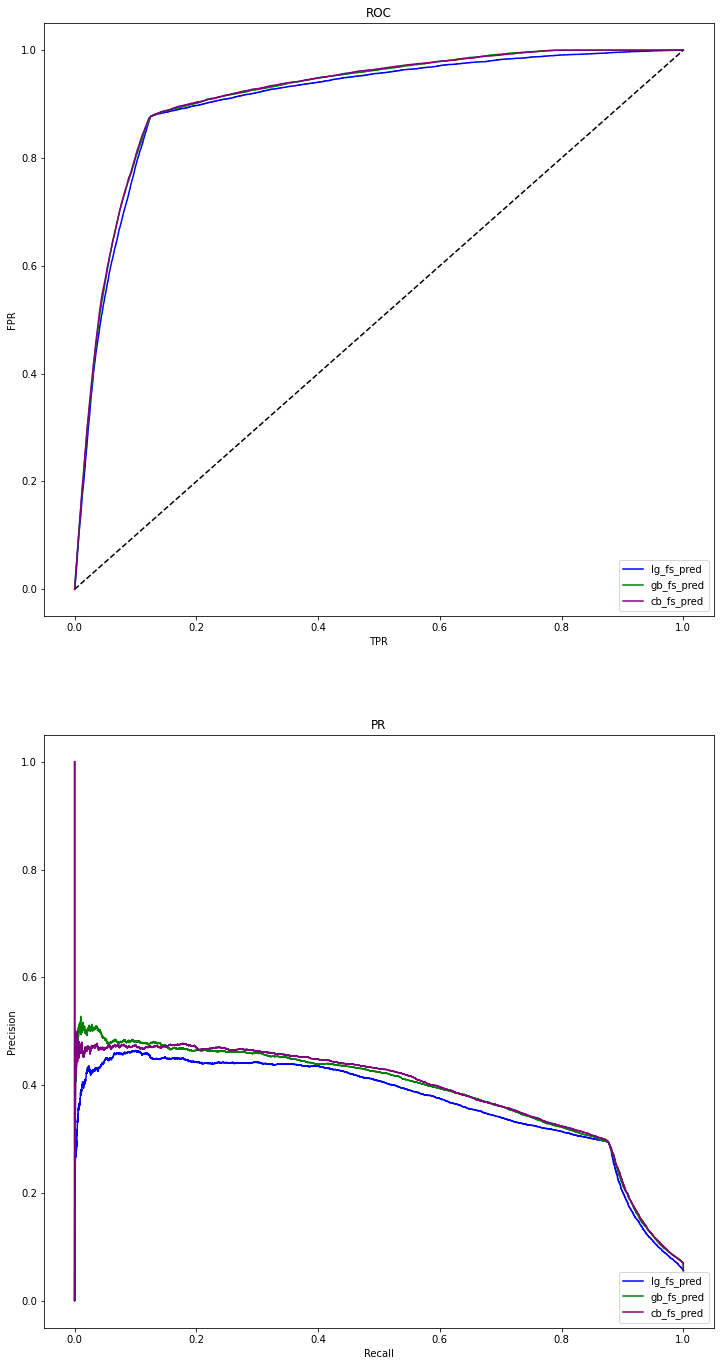

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, lg_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, lg_fs_pred)
ax1.plot(fpr, tpr, label='lg_fs_pred', color='b')
ax2.plot(recall, precision, label='lg_fs_pred', color='b')
print('lg_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('lg_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, gb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, gb_fs_pred)
ax1.plot(fpr, tpr, label='gb_fs_pred', color='g')
ax2.plot(recall, precision, label='gb_fs_pred', color='g')
print('gb_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('gb_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, cb_fs_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, cb_fs_pred)
ax1.plot(fpr, tpr, label='cb_fs_pred', color='purple')
ax2.plot(recall, precision, label='cb_fs_pred', color='purple')
print('cb_fs_pred: AUC_PR = %.3f' % auc(recall, precision))
print('cb_fs_pred: AUC_ROC = %.3f' % auc(fpr, tpr))

ax1.legend(loc='lower right')
ax2.legend(loc='lower right');

##### Видим, что значения близки друг к другу. Выберем CatBoostClassifier, так как эта модель работает быстрее, а также f1 (average='macro') выше, чем у GradientBoostingClassifier: 0.69.

In [50]:
def plot_confusion_matrix(cm, classes,
                          model_name='',
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color='white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[166996  23840]
 [  1396   9953]]


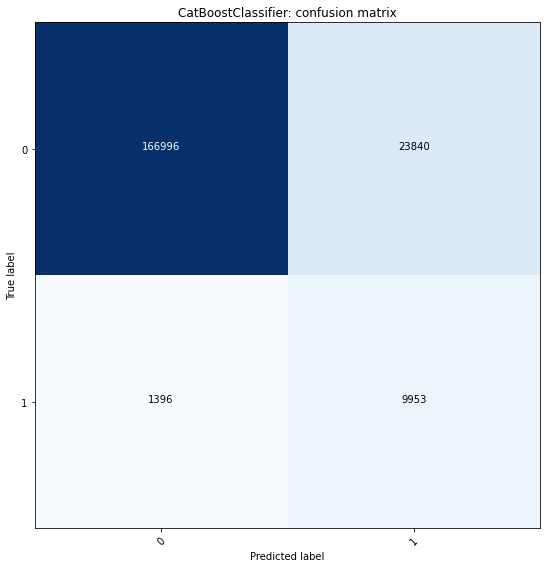

In [51]:
cm = confusion_matrix(y_test, cb_fs_pred > 0.5)
plot_confusion_matrix(cm, classes=['0', '1'], model_name='CatBoostClassifier');

##### Значение 0.5 является оптимальным порогом вероятности для отнесения к положительному классу и предложения абоненту услуги. Если взять порог ниже (например, 0.4), то результат f1 macro ухудшается, как и accuracy.

#### Запишем выбранную модель в файл в формате pickle

In [52]:
with open('cat_boost_classifier_model.pickle', 'wb') as f:
    pickle.dump(cb_fs_pipe_final, f, protocol=pickle.HIGHEST_PROTOCOL)

#### Предсказание на тестовой выборке

In [53]:
with open('cat_boost_classifier_model.pickle', 'rb') as f:
    cb_fs_pipe_final = pickle.load(f)

In [54]:
test_data = pd.read_csv('test_data_features.csv')

In [55]:
y_pred = cb_fs_pipe_final.predict_proba(test_data)[:, 1]

In [56]:
y_pred

array([0.13865518, 0.18779556, 0.87123444, ..., 0.16443223, 0.93293332,
       0.1873857 ])

In [57]:
X_test = pd.read_csv('data_test.csv')
X_test = X_test.drop('Unnamed: 0', axis=1)

ids_dict = {1.0: 1, 2.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 7.0: 6, 8.0: 7, 9.0: 8}
X_test['vas_id'] = X_test['vas_id'].map(ids_dict)

In [58]:
X_test['target'] = y_pred

In [59]:
X_test.to_csv('answers_test.csv', index=False)

In [60]:
X_test.head(4)

,id,vas_id,buy_time,target
0,3130519,2,1548018000,0.138655
1,2000860,3,1548018000,0.187796
2,1099444,2,1546808400,0.871234
3,1343255,4,1547413200,0.858708
